In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
from multiprocessing import Pool
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import multiprocessing
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import config

In [4]:
path = Path('data/yelp_dataset/')
assert path.exists()

In [5]:
!ls {path}

Dataset_User_Agreement.pdf           yelp_academic_dataset_review.json
balanced_simplified_reviews_full.pkl yelp_academic_dataset_tip.json
yelp_academic_dataset_business.json  yelp_academic_dataset_user.json
yelp_academic_dataset_checkin.json   yelp_reviews_simple_8021122.json


In [7]:
balanced_simplified_reviews = pd.read_pickle(path/'balanced_simplified_reviews_full.pkl')

In [8]:
balanced_simplified_reviews['stars'] = balanced_simplified_reviews['stars'] - 1
balanced_simplified_reviews

,text,stars
31,This actually used to be one of my favorite ho...,1
62,Decent food. Fishermen lobster or even congee ...,1
77,"Pros: Fun atmosphere, great for people watchin...",1
85,"I love bookstores, and I love to spend some ti...",1
86,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",1
...,...,...
8021116,"Fricken unbelievable, I ordered 2 space heater...",0
8021117,Solid American food with a southern comfort fl...,2
8021118,I'm honestly not sure how I have never been to...,4
8021119,Food was decent but I will say the service too...,2


### Preparing tokenziser and data loaders

In [9]:
NUM_CLASSES = len(balanced_simplified_reviews['stars'].unique())

In [10]:
tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_MODEL_NAME)

In [35]:
tokenizer.max_model_input_sizes

{'bert-base-uncased': 512,
 'bert-large-uncased': 512,
 'bert-base-cased': 512,
 'bert-large-cased': 512,
 'bert-base-multilingual-uncased': 512,
 'bert-base-multilingual-cased': 512,
 'bert-base-chinese': 512,
 'bert-base-german-cased': 512,
 'bert-large-uncased-whole-word-masking': 512,
 'bert-large-cased-whole-word-masking': 512,
 'bert-large-uncased-whole-word-masking-finetuned-squad': 512,
 'bert-large-cased-whole-word-masking-finetuned-squad': 512,
 'bert-base-cased-finetuned-mrpc': 512,
 'bert-base-german-dbmdz-cased': 512,
 'bert-base-german-dbmdz-uncased': 512,
 'TurkuNLP/bert-base-finnish-cased-v1': 512,
 'TurkuNLP/bert-base-finnish-uncased-v1': 512,
 'wietsedv/bert-base-dutch-cased': 512}

In [11]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [33]:
def count_tokens(df):
    df['text_len'] = df['text'].apply(lambda t : len(tokenizer.encode(t, max_length=config.MAX_LENGTH,truncation=True)))
    return df

In [34]:
%%time

balanced_simplified_reviews = parallelize_dataframe(balanced_simplified_reviews, count_tokens, 10)

CPU times: user 10.1 s, sys: 29.4 s, total: 39.5 s
Wall time: 17min 40s


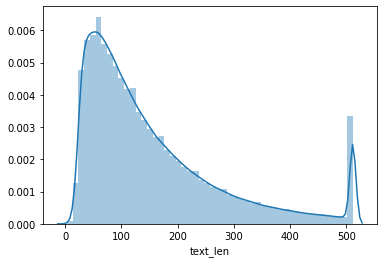

In [36]:
sns.distplot(balanced_simplified_reviews['text_len'])


In [37]:
class YelpDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews, self.targets,  self.tokenizer, self.max_len = reviews.to_numpy(), targets.to_numpy(), tokenizer, max_len
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, item):
        review = self.reviews[item]
        tokens = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'review': review,
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
            'target': torch.tensor(self.targets[item]).long()
        }

In [38]:
RANDOM_SEED = 42

def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [39]:
train_df, test_df = train_test_split(balanced_simplified_reviews, test_size=0.1, random_state=RANDOM_SEED, 
                                     stratify=balanced_simplified_reviews.stars.values)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=RANDOM_SEED, stratify=test_df.stars.values)
train_df.shape, test_df.shape, valid_df.shape

((2857820, 3), (158768, 3), (158768, 3))

Checking if the distribution is even. We used stratify so it should be.

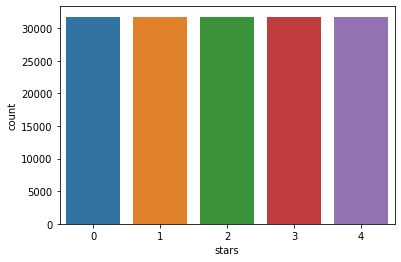

In [40]:
sns.countplot(valid_df['stars'])

In [41]:
def create_data_loader(df, tokenizer, max_length, batch_size):
    ds = YelpDataset(df['text'], df['stars'], tokenizer, max_length)
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=multiprocessing.cpu_count() - 1
    )

In [45]:
BATCH_SIZE=16

train_dl = create_data_loader(train_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
test_dl = create_data_loader(test_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)
valid_dl = create_data_loader(valid_df, tokenizer, config.MAX_LENGTH, BATCH_SIZE)

In [46]:
sample_record = next(iter(train_dl))
sample_record['input_ids'][0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

tensor([  101,  1109,  2166,  3189,  1108,  2385, 14739,   117,  1463,  5953,
         1110,  1136,   109,   124,  1112,  9129,   117,  1133,   109,   124,
          119,  4850,  1105,  1146,   119, 18491,  1174,  1103,   109,   123,
        20049, 25754,  6462,  1105,  1122,  1108,  2385,  4296,  1107,  3849,
          119,  2907,  2802,   170,  6707, 16091, 19557,  2728,   117,  1134,
         1108, 11858,   117,  1105,  1103,   158,  3842,  1302,  5412,  1513,
         1573,  4455,  1111,   109,   124,   119,  4850,  1108,  2785, 16047,
          119, 20394,  5773,  1183,   190,  3842,  1185, 27267,  1114,   170,
         4778,  9304, 12858,   119,  1370,  1115,  3945,  1463,   117,  1122,
         1156,   112,  1396,  1151,  1618,  1191,  1175,  1127,  1199, 27001,
         1116,  1107,  1103, 13128,   119,  3982,  1500,  1118,  2546,  1115,
         1147,  7253,  1733,  1132,  2785,  1363,   119,  1448,  1111,   109,
          122,   119,  1851,   117,  1105,  1175,   112,   188, 

In [47]:
sample_record['attention_mask'][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Prepare training

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [49]:
model = BertForSequenceClassification.from_pretrained(config.PRE_TRAINED_MODEL_NAME, num_labels = NUM_CLASSES, 
                                                      output_attentions = False, output_hidden_states = False)
model = model.to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [50]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-3},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [51]:
len([p for n, p in param_optimizer if not any(nd in n for nd in no_decay)]), len([p for n, p in param_optimizer if any(nd in n for nd in no_decay)])


(77, 124)

In [52]:
# AdamW Adam algorithm with weight decay fix
optimizer = AdamW(optimizer_parameters, 
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

In [53]:
EPOCHS = 3

total_steps = len(train_dl) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [54]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [55]:
import os
import shutil
import pickle

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

def save_model(model, tokenizer, output_dir = path/'model_save'):

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    else:
        shutil.rmtree(output_dir)
        os.makedirs(output_dir)

    print(f"Saving model to {output_dir}")

    tokenizer.save_pretrained(output_dir)
    torch.save(model, output_dir/'model')

## Training Loop

In [56]:
def grab_batch_data(batch):
    input_ids = batch['input_ids'].to(device)
    input_mask = batch['attention_mask'].to(device)
    labels = batch['target'].to(device)
    return input_ids, input_mask, labels

def eval_fn():
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    # Evaluate data for one epoch
    for batch in tqdm(valid_dl, total=len(valid_dl)):
        input_ids, input_mask, labels = grab_batch_data(batch)
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            (loss, logits) = model(input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=input_mask,
                                   labels=labels)
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
    avg_val_accuracy = total_eval_accuracy / len(valid_dl)
    avg_val_loss = total_eval_loss / len(valid_dl)
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation Loss: {avg_val_loss:.2f}")
    return {
        'Accuracy': avg_val_accuracy,
        'Validation Loss': avg_val_loss
    }

In [ ]:

# training_stats = []
# best_accuracy = 0

for epoch in tqdm(range(0, EPOCHS), total=EPOCHS):
    total_train_loss = 0
    model.train()
    
    train_loss_set = []
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0 
    
    for step, batch in tqdm(enumerate(train_dl), total=len(train_dl)):
        # Unpack the inputs from dataloader
        input_ids, input_mask, labels = grab_batch_data(batch)
        # Clear ou the gradients
        optimizer.zero_grad() 
        # Forward pass
        loss = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        scheduler.step()
        
#         if step % 2000 == 0:
#             print(f'{step}: Loss: {total_train_loss / (step + 1)}\r')
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dl)
    print("")
    print(f"  Average training loss: {avg_train_loss}")
    stats_info = eval_fn()
    stats_info['epoch'], stats_info['Average training loss'] = epoch, avg_train_loss
    training_stats.append(stats_info)
    save_model(model, tokenizer, output_dir=path/f'output_dir_{epoch}')
    if stats_info['Accuracy'] > best_accuracy:
        save_model(model, tokenizer, output_dir=path/f'output_dir_best')
        best_accuracy = stats_info['Accuracy']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad 

In [82]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [60]:
total_train_loss

0

In [62]:
print(train_dl)

In [81]:
output = model(input_ids[:4,:], token_type_ids=None, attention_mask=input_mask, labels=labels[:4,:])


IndexError: too many indices for tensor of dimension 1

In [78]:
logits

'logits'

In [71]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_convert_head_mask_to_5d',
 '_expand_inputs_for_generation',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_decoder_start_token_id',
 '_get_logits_processor',
 '_get_logits_warper',
 '_get_name',
 '_get_pad_token_id',
 '_get_resized_embeddings',
 '_hook_rss_memory_post_forward',
 '_hook_rss_memory_pre_forward',
 '_init_sequence_length_for_generation',
 '_init_weights',
 '_keys_to_ignore_on_load_missing',
 '_keys_to_ignore_on_load_unexpected',
 '_keys_to_ignore_on_save',
 '_load_

In [73]:
print(model.train.__doc__)

Sets the module in training mode.

        This has any effect only on certain modules. See documentations of
        particular modules for details of their behaviors in training/evaluation
        mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
        etc.

        Args:
            mode (bool): whether to set training mode (``True``) or evaluation
                         mode (``False``). Default: ``True``.

        Returns:
            Module: self
        


In [74]:
print(model.zero_grad.__doc__)

Sets gradients of all model parameters to zero. See similar function
        under :class:`torch.optim.Optimizer` for more context.

        Arguments:
            set_to_none (bool): instead of setting to zero, set the grads to None.
                See :meth:`torch.optim.Optimizer.zero_grad` for details.
        


In [75]:
model.__call__

<bound method Module._call_impl of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L